# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
from torchvision import transforms
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img:resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

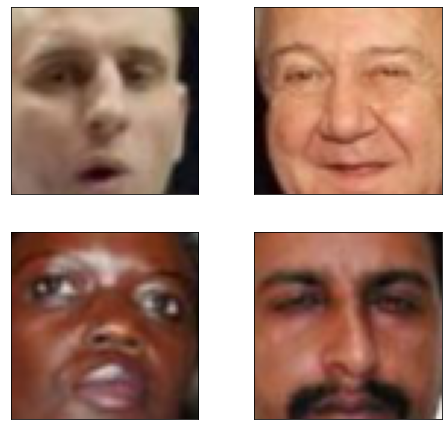

In [ ]:
#this will split our data into train and validation + show some images

train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

plt.figure(figsize=(8, 20))
for i, gt in enumerate(val_data[:-5:-1]):
  plt.subplot(5, 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(gt)

In [ ]:
#and this will convert the data to tensors and shove it into Dataloaders

BATCH_SIZE = 26

train_data_tensor = torch.FloatTensor(train_data).permute(0,3,1,2)
val_data_tensor = torch.FloatTensor(val_data).permute(0,3,1,2)

train_loader = torch.utils.data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_data_tensor, batch_size=BATCH_SIZE, num_workers = 2)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),

            nn.Flatten(start_dim = 1),
            nn.Linear(16384, 512)
        )

        self.decoder = nn.Sequential(
            nn.Linear(512, 16384),
            nn.Unflatten(dim = 1, unflattened_size = (64, 16, 16)),

            nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 0,  output_padding = 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

    def sample(self, sample):
        reconstruction = self.decoder(sample)
        return reconstruction

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
!nvidia-smi

True
Tue Dec 20 17:21:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      3MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
criterion = F.mse_loss
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 3e-4)

n_epochs = 20

In [ ]:
def train(train_loader, val_loader,
          autoencoder, criterion, optimizer, epochs):

    best_weights = deepcopy(autoencoder.state_dict())
    best_loss = 100
    train_losses = []
    val_losses = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):

            autoencoder.train()
            train_losses_per_epoch = []
            for i, X_batch in enumerate(train_loader):
                optimizer.zero_grad()
                reconstructed, latent_code = autoencoder(X_batch.to(device))
                loss = criterion(reconstructed, X_batch.to(device))
                loss.backward()
                optimizer.step()
                train_losses_per_epoch.append(loss.item())

            train_losses.append(np.mean(train_losses_per_epoch))
            print("loss", np.mean(train_losses_per_epoch))

            autoencoder.eval()
            val_losses_per_epoch = []

            with torch.no_grad():
                for X_batch in val_loader:
                  reconstructed, latent_code = autoencoder(X_batch.to(device))
                  loss = criterion(reconstructed, X_batch.to(device))
                  val_losses_per_epoch.append(loss.item())

            val_losses.append(np.mean(val_losses_per_epoch))
            print("loss", np.mean(val_losses_per_epoch))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep = epoch + 1, t_loss = np.mean(train_losses_per_epoch), v_loss = np.mean(val_losses_per_epoch)))

            if np.mean(val_losses_per_epoch) < best_loss:
                best_acc = np.mean(val_losses_per_epoch)
                best_weights = deepcopy(autoencoder.state_dict())


            # Visualize tools
            clear_output(wait=True)
            fig = plt.figure(figsize=(12,6))
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(X_batch[k].permute(1,2,0))
                plt.title('Original')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(reconstructed[k].detach().cpu().permute(1,2,0))
                plt.title('Reconstructed')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, np.mean(val_losses_per_epoch)))
            plt.show()

    autoencoder.load_state_dict(best_weights)

    X_batch.to('cpu')
    del autoencoder
    del X_batch
    torch.cuda.empty_cache()

    return train_losses, val_losses

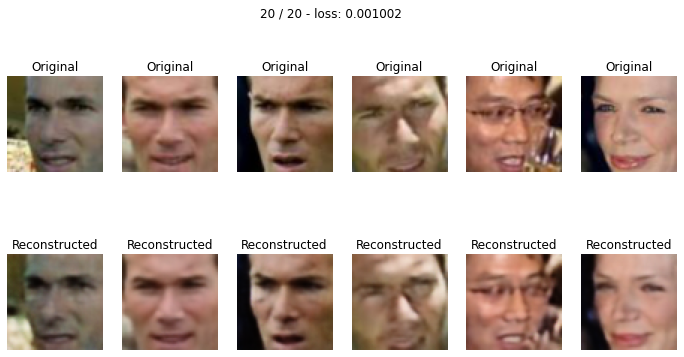

epoch: 100%|██████████| 20/20 [03:14<00:00,  9.72s/it]


In [ ]:
train_losses, val_losses = train(train_loader, val_loader,
                autoencoder = autoencoder, criterion = criterion, optimizer=optimizer, epochs = n_epochs)

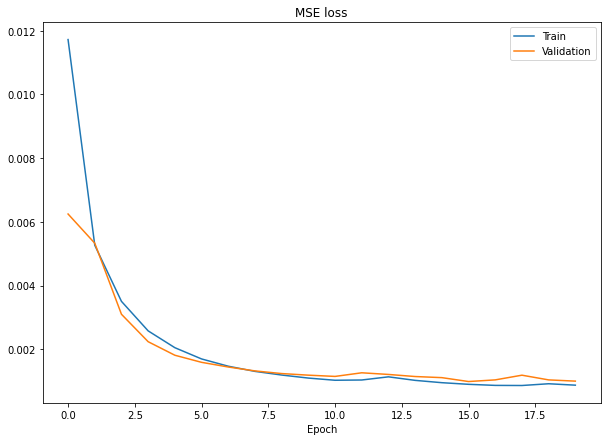

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

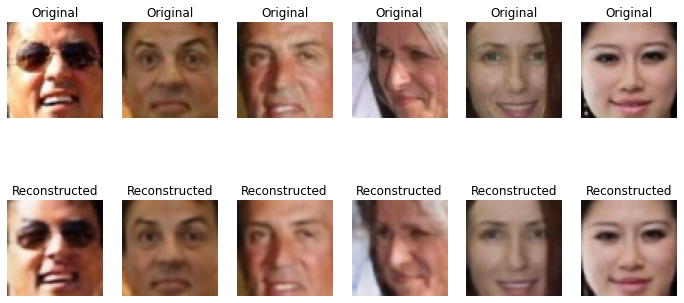

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction, latent_code = autoencoder(batch.to(device))
      break

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(batch[k].permute(1,2,0))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(reconstruction[k].cpu().permute(1,2,0))
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

batch.to('cpu')
torch.cuda.empty_cache()

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Eсли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

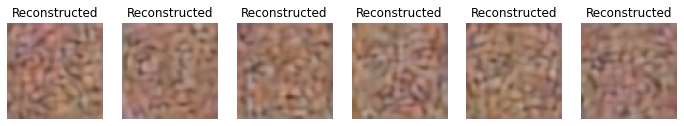

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space

z = np.random.randn(25, 512)
output = autoencoder.sample(torch.FloatTensor(z).to(device))

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+7)
    plt.imshow(output[k].detach().cpu().permute(1,2,0))
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

torch.cuda.empty_cache()

In [ ]:
lat = torch.FloatTensor()

autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        reconstructed, latent_code = autoencoder(batch.to(device))
        lat = torch.cat((lat, latent_code.to('cpu')), dim = 0)
        break

mean = torch.mean(lat)
std = torch.std(lat)

print(f'Mean: {mean}\nStandard deviation: {std}')

Mean: -0.007249268237501383
Standard deviation: 2.9244675636291504


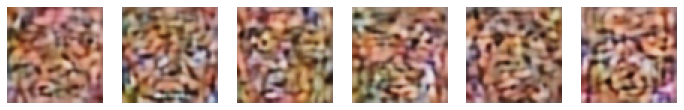

In [ ]:
z = np.random.normal(mean, std, (25, 512))
output = autoencoder.sample(torch.FloatTensor(z).to(device))

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+7)
    plt.imshow(output[k].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.show()

torch.cuda.empty_cache()

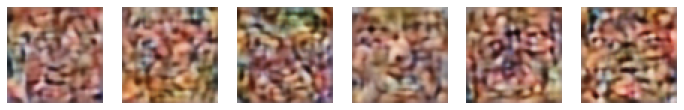

In [ ]:
z = np.random.normal(np.random.normal(0, 0.01, 1), np.random.normal(2.5, 0.1, 1), (25, 512))
output = autoencoder.sample(torch.FloatTensor(z).to(device))

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+7)
    plt.imshow(output[k].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.show()

torch.cuda.empty_cache()

Ну, в целом, стало получше, и на некоторых картинках даже можно попробовать найти лица (главное, не увлекаться, так и до ПНД недалеко)

## Time to have fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.agg(
    {
        "Male": ["min", "max", "mean"],
        "Smiling": ["min", "max", "mean"],
        "Frowning": ["min", "max", "mean"]
    }
)


,Male,Smiling,Frowning
min,-3.672871,-2.686594,-2.953572
max,3.750887,2.839994,2.839384
mean,0.629800,-0.150700,0.148661


In [ ]:
attrs_ = attrs[['Male', 'Smiling', 'Frowning']].where(attrs['Male'] < -2.5).dropna()

frown = attrs_.sort_values('Frowning', ascending = False)
smile = attrs_.sort_values('Smiling', ascending = False)

In [ ]:
frown_id = frown.head(20).index.tolist()
smile_id = smile.head(20).index.tolist()

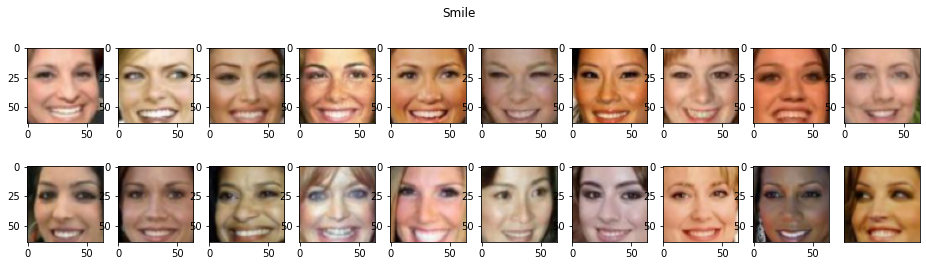

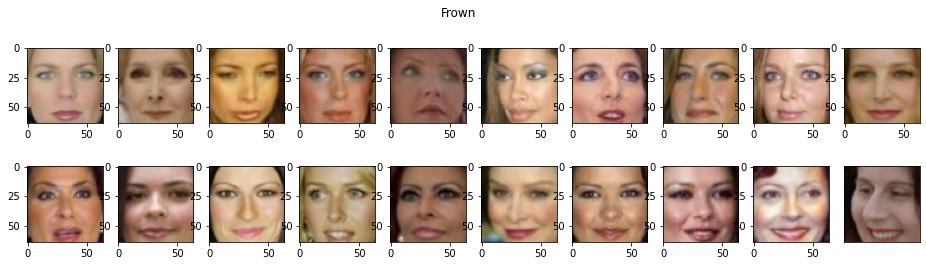

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(16, 4))
index = 0
for fig_x in ax.flatten():
    fig_x.imshow(data[smile_id[index]])
    plt.xticks([])
    plt.yticks([])
    index += 1
plt.suptitle('Smile')
plt.show()


fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(16, 4))
index = 0
for fig_x in ax.flatten():
    fig_x.imshow(data[frown_id[index]])
    plt.xticks([])
    plt.yticks([])
    index += 1
plt.suptitle('Frown')
plt.show()

Выборка хмурящихся не очень хорошая: очевидно, некоторые женщины улыбаются. Изначально я брала выборку из мужчин, но и там была такая же проблема + было много усов, очков и прочих артефактов, которые могли помешать выявлению нужных фичей. Ну да ничего, зато улыбающаяся выборка отличная

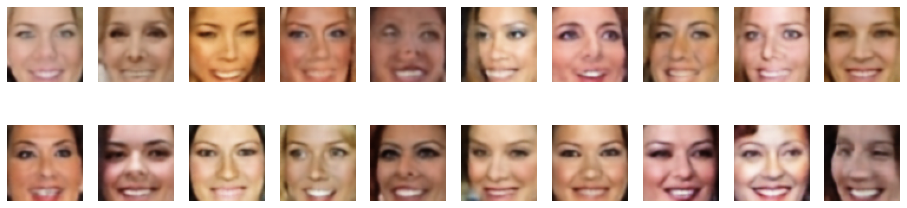

In [ ]:
latent_smile = torch.FloatTensor().to(device)
latent_frown = torch.FloatTensor().to(device)

#finding (nemo) latent vectors (soory, it was late at night)
for i in smile_id:
    smile_img = torch.FloatTensor(data[i]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstruction, lat_smile = autoencoder(smile_img)
    latent_smile = torch.cat((latent_smile, lat_smile))

for i in frown_id:
    frown_img = torch.FloatTensor(data[i]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed, lat_frown = autoencoder(frown_img)
    latent_frown = torch.cat((latent_frown, lat_frown))

#simple math
smile = torch.mean(latent_smile, axis=0) - torch.mean(latent_frown, axis=0)
latent = latent_frown + smile

#(just praying and tarot reading by now
with torch.no_grad():
    output = autoencoder.sample(latent)
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(output[i].cpu().permute(1,2,0))
    plt.axis('off')
plt.show()

Вуаля! Вы восхитительны!

In [ ]:
autoencoder.to("cpu")
del autoencoder
torch.cuda.empty_cache()

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root = './mnist_data/', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = './mnist_data/', train = False, transform = transforms.ToTensor(), download = False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([32, 1, 28, 28])


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        #architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.Flatten(start_dim = 1)
        )

        self.mu = nn.Linear(1024, 4)
        self.logsigma = nn.Linear(1024, 4)

        self.decoder = nn.Sequential(
            nn.Linear(4, 1024),
            nn.Unflatten(dim = 1, unflattened_size = (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 2,  output_padding = 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        #forward with encoder
        x = self.encoder(x)
        return self.mu(x), self.logsigma(x)

    def gaussian_sampler(self, mu, logsigma):
        #get a vector from our distribution / just return mu
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            return mu

    def decode(self, z):
        #forward with decoder / sample
        return self.decoder(z)

    def latent_vector(self, x):
        mu, logsigma = self.encode(x)
        return self.gaussian_sampler(mu, logsigma)

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений
    """
    loss = loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
def train(train_loader, test_loader, autoencoder, criterion, optimizer, epochs):

    best_weights = deepcopy(autoencoder.state_dict())
    best_loss = 100000
    train_losses = []
    val_losses = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):

            #train
            autoencoder.train()
            train_losses_per_epoch = []
            for batch_id, (batch, _) in enumerate(train_loader):
                optimizer.zero_grad()
                reconstruction, mu, logsigma = autoencoder(batch.to(device))
                loss = criterion(batch.to(device), mu, logsigma, reconstruction)
                loss.backward()
                optimizer.step()
                train_losses_per_epoch.append(loss.item())

            train_losses.append(np.mean(train_losses_per_epoch))
            print("loss", np.mean(train_losses_per_epoch))

            #check on validation
            autoencoder.eval()
            val_losses_per_epoch = []
            with torch.no_grad():
                for batch_id, (batch, _) in enumerate(test_loader):
                    reconstruction, mu, logsigma = autoencoder(batch.to(device))
                    loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
                    val_losses_per_epoch.append(loss.item())

            val_losses.append(np.mean(val_losses_per_epoch))
            print("loss", np.mean(val_losses_per_epoch))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep = epoch + 1, t_loss = np.mean(train_losses_per_epoch), v_loss = np.mean(val_losses_per_epoch)))

            #compare current loss to the best one and save it if it's less
            if np.mean(val_losses_per_epoch) < best_loss:
                best_acc = np.mean(val_losses_per_epoch)
                best_weights = deepcopy(autoencoder.state_dict())

            # visualize
            clear_output(wait=True)
            fig = plt.figure(figsize=(12,6))
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(batch[k].detach().cpu().squeeze(0), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(reconstruction[k].detach().cpu().squeeze(0), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, np.mean(val_losses_per_epoch)))
            plt.show()

    autoencoder.load_state_dict(best_weights)

    batch.to('cpu')
    del autoencoder
    del batch
    torch.cuda.empty_cache()

    return train_losses, val_losses

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 20

criterion = loss_vae
vae_autoencoder = VAE().to(device)
optimizer = torch.optim.Adam(vae_autoencoder.parameters(), lr = 3e-4)

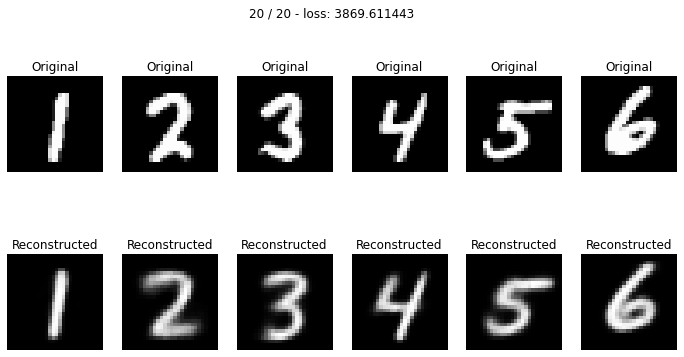

epoch: 100%|██████████| 20/20 [07:14<00:00, 21.71s/it]


In [ ]:
train_losses, val_losses = train(train_loader, test_loader, vae_autoencoder, criterion = criterion, optimizer = optimizer, epochs = n_epochs)

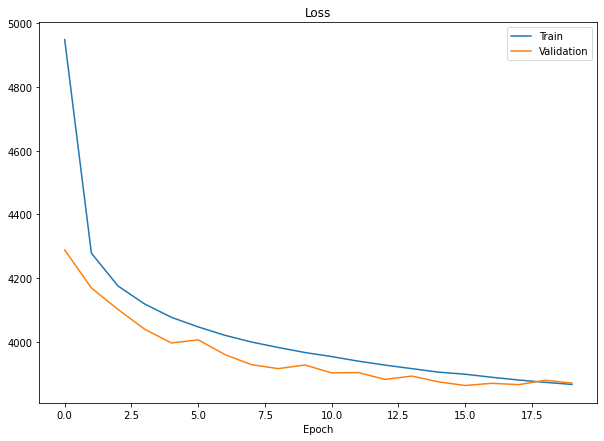

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

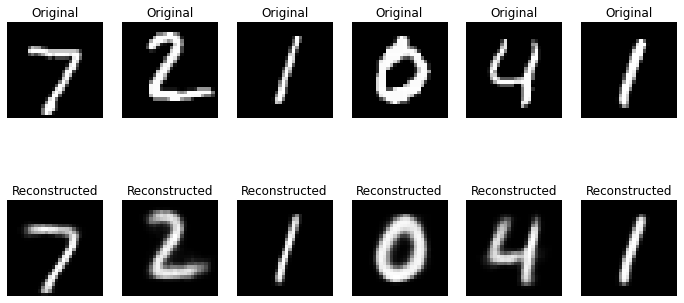

In [ ]:
vae_autoencoder.eval()
with torch.no_grad():
    for batch_id, (batch, _) in enumerate(test_loader):
        reconstruction, mu, logsigma = vae_autoencoder(batch.to(device))
        break

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(batch[k].detach().cpu().squeeze(0), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(reconstruction[k].detach().cpu().squeeze(0), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

batch.to('cpu')
torch.cuda.empty_cache()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

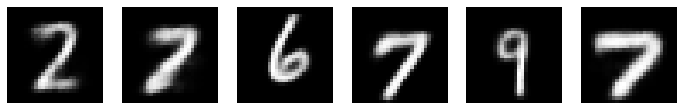

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 4) for i in range(10)])
z = torch.FloatTensor(z)

vae_autoencoder.eval()
with torch.no_grad():
    output = vae_autoencoder.decode(z.to(device))

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+7)
    plt.imshow(output[k].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.show()

torch.cuda.empty_cache()

Получается гораздо лучше. Конечно, и датасет другой, так что прямое сравнение несколько некорректно. Однако все-таки можно сказать, что VAE лучше подходит для генерации новых изображений, чем обычный автоэнкодер, благодаря непрерывности скрытого пространства и привнесенной доле вариативности на входе декодера.

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
latent = torch.FloatTensor()
for i in test_loader:
    img = i[0]
    vae_autoencoder.eval()
    with torch.no_grad():
        lat = vae_autoencoder.latent_vector(img.to(device))
    latent = torch.cat((latent, lat.cpu()))

In [ ]:
labels = [i[1] for i in test_dataset]

In [ ]:
latent_tsne = TSNE(2).fit_transform(latent)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


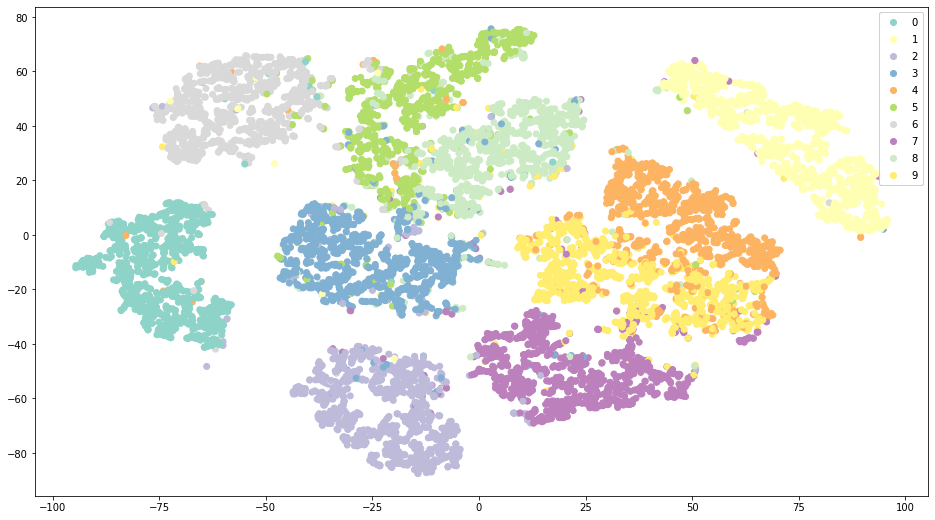

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
scatter = ax.scatter(x = latent_tsne[:, 0], y = latent_tsne[:, 1], c = labels, cmap = 'Set3')
legend = ax.legend(*scatter.legend_elements(), loc="upper right")
ax.add_artist(legend)
plt.show()

Что вы думаете о виде латентного представления?

Большинство кластеров - например, 0, 1, 2, 6, 7 - разделены очень четко, их границы хорошо видны и почти не пересекаются с другими кластерами. Но некоторые - 3, 8 и 5, а также 4 и 9 - кое-где близко соседствуют и даже накладываются друг на друга, что отражает сходство в рукописном написании этих цифр.

__Congrats v2.0!__

In [ ]:
vae_autoencoder.to("cpu")
del vae_autoencoder
torch.cuda.empty_cache()

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
img_size = 28 * 28
img_channels = 1
n_classes = 10

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.class_ = nn.Linear(n_classes, img_size)

        #architecture
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(img_channels + 1, img_channels, kernel_size = 1, padding = 0, output_padding = 0),
            nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.Flatten(start_dim = 1)
        )

        self.mu = nn.Linear(1024, 4)
        self.logsigma = nn.Linear(1024, 4)

        self.decoder = nn.Sequential(
            nn.Linear(img_size + 4, 1024),
            nn.Unflatten(dim = 1, unflattened_size = (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 2,  output_padding = 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        #forward with encoder
        classes = F.one_hot(class_num, num_classes = n_classes)
        classes = classes.type_as(torch.FloatTensor()).to(device)
        class_num = self.class_(classes)
        x = torch.cat([x, class_num.view(-1, 28, 28).unsqueeze(1)], dim = 1)

        x = self.encoder(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        #return a vector from the given distribution / mu
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            return mu

    def decode(self, z):
        #forward with decoder
        reconstruction = self.decoder(z)
        return reconstruction

    def latent_vector(self, x, class_num):
        #get the generated latent vector
        mu, logsigma, classes = self.encode(x, class_num)
        return self.gaussian_sampler(mu, logsigma)

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        z = torch.cat([z, class_num], dim = 1)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

In [ ]:
def KL_divergence(mu, logsigma):
    loss = loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
def train(train_loader, test_loader, autoencoder, criterion, optimizer, epochs):

    best_weights = deepcopy(autoencoder.state_dict())
    best_loss = 100000
    train_losses = []
    val_losses = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):

            #train
            autoencoder.train()
            train_losses_per_epoch = []
            for batch_id, (batch, class_num) in enumerate(train_loader):
                optimizer.zero_grad()
                reconstruction, mu, logsigma = autoencoder(batch.to(device), class_num.to(device))
                loss = criterion(batch.to(device), mu, logsigma, reconstruction)
                loss.backward()
                optimizer.step()
                train_losses_per_epoch.append(loss.item())

            train_losses.append(np.mean(train_losses_per_epoch))
            print("loss", np.mean(train_losses_per_epoch))

            autoencoder.eval()
            val_losses_per_epoch = []

            #test on validation
            with torch.no_grad():
                for batch_id, (batch, class_num) in enumerate(test_loader):
                    reconstruction, mu, logsigma = autoencoder(batch.to(device), class_num.to(device))
                    loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
                    val_losses_per_epoch.append(loss.item())

            val_losses.append(np.mean(val_losses_per_epoch))
            print("loss", np.mean(val_losses_per_epoch))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep = epoch + 1, t_loss = np.mean(train_losses_per_epoch), v_loss = np.mean(val_losses_per_epoch)))

            #compare losses, choose the best one
            if np.mean(val_losses_per_epoch) < best_loss:
                best_acc = np.mean(val_losses_per_epoch)
                best_weights = deepcopy(autoencoder.state_dict())

            #visualize
            clear_output(wait=True)
            fig = plt.figure(figsize=(12,6))
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(batch[k].detach().cpu().squeeze(0), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(reconstruction[k].detach().cpu().squeeze(0), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, np.mean(val_losses_per_epoch)))
            plt.show()

    autoencoder.load_state_dict(best_weights)

    batch.to('cpu')
    class_num.to('cpu')
    del autoencoder
    del batch
    del class_num
    torch.cuda.empty_cache()

    return train_losses, val_losses

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 40

criterion = loss_vae
cvae_autoencoder = CVAE().to(device)
optimizer = torch.optim.Adam(cvae_autoencoder.parameters(), lr = 3e-4)

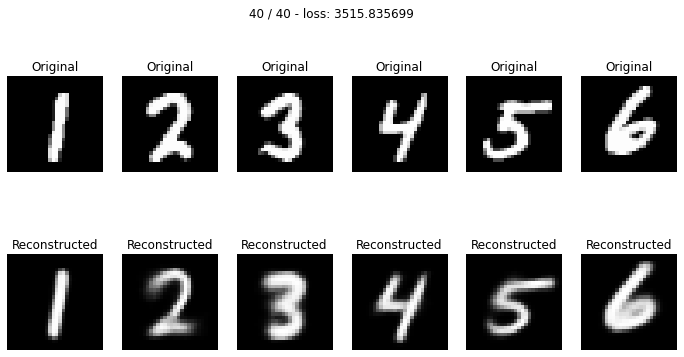

epoch: 100%|██████████| 40/40 [14:23<00:00, 21.58s/it]


In [ ]:
train_losses, val_losses = train(train_loader, test_loader, cvae_autoencoder, criterion = criterion, optimizer = optimizer, epochs = n_epochs)

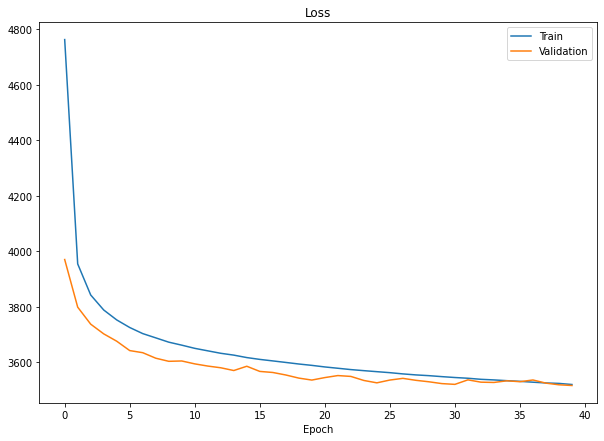

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

torch.Size([10, 778]) torch.Size([10, 10])


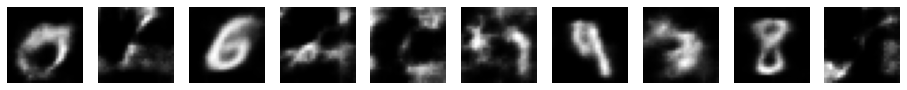

In [ ]:
z = np.array([np.random.normal(0, 1, 778) for i in range(10)])
z = torch.FloatTensor(z)
class_num = list(range(10))
class_num = F.one_hot(torch.FloatTensor(class_num).to(torch.int64), n_classes)
print(z.shape, class_num.shape)
z = torch.cat([z, class_num], dim = 1)

cvae_autoencoder.eval()
with torch.no_grad():
    output = cvae_autoencoder.decode(z.to(device))

fig, ax = plt.subplots(1, 10, figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(output[i].cpu().squeeze(0), cmap = 'gray')
    plt.axis('off')
plt.show()

torch.cuda.empty_cache()

Splendid! Вы великолепны!


Хоть это и одна из многих случайных выборок, большинство которых были не очень удачными, эта вполне хороша. 0, 1, 7 и 8 видны достаточно отчетливо, 6 "превратилась" в 9, а 2 - в 6

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


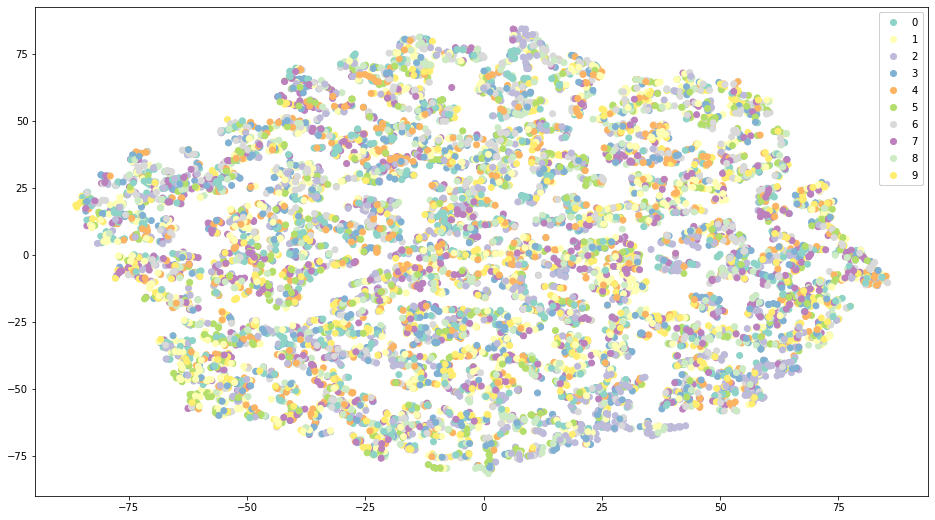

In [ ]:
latent = torch.FloatTensor()
for i in test_loader:
    img, class_num = i
    cvae_autoencoder.eval()
    with torch.no_grad():
        lat = cvae_autoencoder.latent_vector(img.to(device), class_num.to(device))
    latent = torch.cat((latent, lat.cpu()))

labels = [i[1] for i in test_dataset]
latent_tsne = TSNE(2).fit_transform(latent)

fig, ax = plt.subplots(figsize=(16,9))
scatter = ax.scatter(x = latent_tsne[:, 0], y = latent_tsne[:, 1], c = labels, cmap = 'Set3')
legend = ax.legend(*scatter.legend_elements(), loc="upper right")
ax.add_artist(legend)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Ага, и сильно. Видно, что классы перемешаны, и нет четкого обособления кластеров, что логично, раз CVAE потенциально может восстановить любую цифру из рандомного вектора.

In [ ]:
cvae_autoencoder.to("cpu")
del cvae_autoencoder
torch.cuda.empty_cache()